In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from DataLoader import DataLoader
import datetime
import random
import warnings
from BehaviourFeatureExtractor import BehaviourFeatureExtractor, plot_mouse_angle_to_pup

## Reading and loading data ##

In [2]:
data_dir = "data"
DL = DataLoader(data_dir, path_to_config_file = "config.json")

Found items ['.DS_Store', 'MBI5335RR'] at directory data
Found items ['.DS_Store', 'MBI5335RR_240309_d6', 'MBI5335RR_240305_d2', 'MBI5335RR_240304_d1', 'MBI5335RR_240308_d5', 'MBI5335RR_240306_d3', 'MBI5335RR_240307_d4'] at directory data/MBI5335RR
Found items ['MBI5335RR_240309_d6_Avisoft', 'MBI5335RR_240309_d6_Behavior'] at directory data/MBI5335RR/MBI5335RR_240309_d6
Found items ['MBI5335RR_240309_d6_Avisoft_concatenated 2024-04-21  2_08 PM_Stats_SYNCCORRECTED.xlsx'] at directory data/MBI5335RR/MBI5335RR_240309_d6/MBI5335RR_240309_d6_Avisoft
Found items ['MBI5335RR_d6DLC_resnet50_ESM-maternal-learningJun18shuffle1_100000.csv', 'MBI5335RR_240309_d6_BehavSummary.csv'] at directory data/MBI5335RR/MBI5335RR_240309_d6/MBI5335RR_240309_d6_Behavior
Found items ['MBI5335RR_240305_d2_Behavior', 'MBI5335RR_240305_d2_Avisoft'] at directory data/MBI5335RR/MBI5335RR_240305_d2
Found items ['MBI5335RR_240305_d2_BehavSummary.csv', 'MBI5335RR_d2DLC_resnet50_ESM-maternal-learningJun18shuffle1_100000.

## Data Exploration ##

##### Day 1 trials #####

In [3]:
# get data for d1 experiment
day1_data = DL.get_data_for_experiment(mouse_id = "MBI5335RR",
                                       day = "d1")

# fill out dataframes
df_summary = day1_data['Behavior']['df_summary']
df_DLC = day1_data['Behavior']['df_dlc']

<Axes: xlabel='pup_x'>

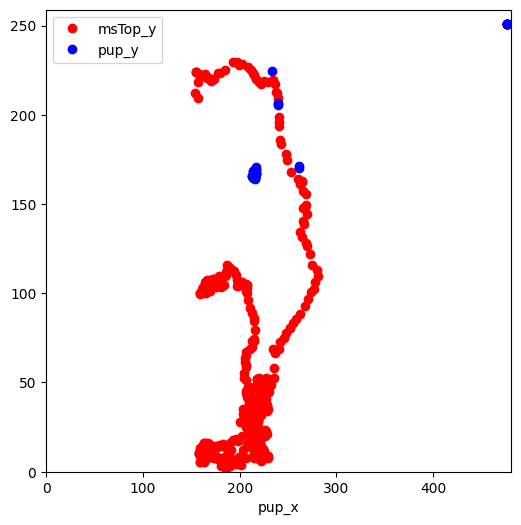

In [4]:
# create a grid of 1 x 2 plots
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ylim = max(df_DLC['msTop_y'].max(), df_DLC['pup_y'].max())
xlim = max(df_DLC['msTop_x'].max(), df_DLC['pup_x'].max())

# color the points with the time
df_DLC.iloc[1000:1500].plot(x='msTop_x', y='msTop_y', style='o', ax=ax, xlim=(0, xlim), ylim=(0, ylim), color = 'r')
df_DLC.iloc[1000:1500].plot(x='pup_x', y='pup_y', style='o', ax=ax,xlim=(0, xlim), ylim=(0, ylim), color = 'b')


In [5]:
df_summary.head(3)

,Group,AnimalID,ExptID,TrialNum,PupDisplPosition,BehavRecdTrialStartSecs,BehavRecdTrialEndSecs,PupDispDropSecs,MouseFirstPickUpPupSecs,DropPupNestSecs,TrialDesignAchieved,EndHabituation,OptoUsed,OptoStartSecs,OptoEndSecs,Features,Notes
0,M,MBI5335RR,d1,1,2,362.042,384.586,369.082,382.266,384.586,1,273.378,0,0,0,0,0
1,M,MBI5335RR,d1,2,3,390.098,402.842,396.698,399.682,402.842,1,273.378,0,0,0,0,0
2,M,MBI5335RR,d1,3,1,411.082,494.930,415.186,491.418,494.930,1,273.378,0,0,0,0,0


In [6]:
df_DLC.head(3)

,frame_index,time_seconds,msTop_x,msTop_y,msTop_likelihood,endHeadbar_x,endHeadbar_y,endHeadbar_likelihood,earRight_x,earRight_y,...,tailBase_likelihood,nose_x,nose_y,nose_likelihood,centerNest_x,centerNest_y,centerNest_likelihood,pup_x,pup_y,pup_likelihood
151,151,5.033333,170.865509,89.811813,0.961542,190.735977,79.387955,0.943847,174.400299,80.521759,...,0.811119,169.054947,96.152382,0.965620,204.863220,57.566437,0.910896,477.403198,251.108810,0.074489
152,152,5.066667,170.884583,89.919662,0.960909,190.975998,79.499725,0.941302,174.574753,80.326324,...,0.806345,168.950119,96.181671,0.965517,204.960968,57.520256,0.904566,477.380341,251.101379,0.074293
153,153,5.100000,170.883240,90.323051,0.961621,191.376846,80.730232,0.936073,174.205078,80.630722,...,0.751888,169.327026,96.632072,0.967170,205.155075,57.570263,0.890773,477.362000,251.079193,0.073658


## Feature Extraction ##

### BehavSummary + DLC  ###

- **BehavSummary + DLC**
    - Define behavioral windows (e.g: -2 to +2 seconds of each behavioral event)
    - Define behavioral windows pre-event (e.g: -x to 0 seconds of each behavioral event)
    - Find behavioral events (from BehavSummaries; *timing info*) in the DLC position data (*x,y info*):
        - at each behavioral event, where was the mouse and the pup located in the arena?
            - how far was the mouse from the pup?
            - what was the head direction of the mouse (towards the pup) at that point?
            - ‘approach’ trajectory: parse out trajectory of mouse towards pup and try to find a segment which is more ‘direct’/ higher speed
        - For the pre-event behavioral window of MouseFirstPickUpSecs: what is the speed of the mouse? What is the head direction of the mouse?

In [7]:
BF = BehaviourFeatureExtractor("config.json")

trial_1_DLC = BF.extract_trial_from_DLC(df_DLC, df_summary, trial_num = 1)

In [8]:
trial_1_DLC.head(3)

,frame_index,time_seconds,msTop_x,msTop_y,msTop_likelihood,endHeadbar_x,endHeadbar_y,endHeadbar_likelihood,earRight_x,earRight_y,...,tailBase_likelihood,nose_x,nose_y,nose_likelihood,centerNest_x,centerNest_y,centerNest_likelihood,pup_x,pup_y,pup_likelihood
11072,11072,369.066667,211.098618,66.026276,0.262119,194.405746,59.853741,0.227935,185.651154,50.854977,...,0.900645,170.046753,33.853313,0.019117,210.619659,53.469929,0.916788,476.207092,250.759369,0.072639
11073,11073,369.100000,203.101562,44.883198,0.139015,197.106476,60.143154,0.255601,202.642029,74.405647,...,0.978901,205.067261,76.075760,0.016486,206.960358,59.180382,0.923038,476.192139,250.844788,0.073462
11074,11074,369.133333,213.183609,66.150902,0.735463,200.254944,52.229858,0.362945,206.455994,69.558716,...,0.891270,219.067657,74.023277,0.189543,207.351913,60.387650,0.968162,476.192780,250.845016,0.073472


Display full trial

<Axes: xlabel='pup_x'>

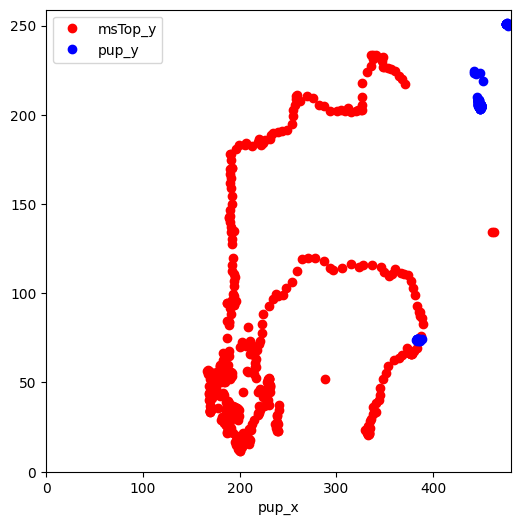

In [9]:
# plot mouse and pup positions
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

xlim, ylim =  max(df_DLC['msTop_x'].max(), df_DLC['pup_x'].max()), max(df_DLC['msTop_y'].max(), df_DLC['pup_y'].max())

trial_1_DLC.plot(x='msTop_x', y='msTop_y', style='o', ax=ax, xlim=(0, xlim), ylim=(0, ylim), color = 'r')
trial_1_DLC.plot(x='pup_x', y='pup_y', style='o', ax=ax,xlim=(0, xlim), ylim=(0, ylim), color = 'b')

#### Quality Checks on low likelihood coords ####

In [10]:
# might be a part of a config file

dict_body_parts_to_coords = {
    "centerNest": {"x": "centerNest_x", "y": "centerNest_y", "likelihood": "centerNest_likelihood"},
    "nose": {"x": "nose_x", "y": "nose_y", "likelihood": "nose_likelihood"},
    "earRight": {"x": "earRight_x", "y": "earRight_y", "likelihood": "earRight_likelihood"},
    "earLeft": {"x": "earLeft_x", "y": "earLeft_y", "likelihood": "earLeft_likelihood"},
    "tailBase": {"x": "tailBase_x", "y": "tailBase_y", "likelihood": "tailBase_likelihood"},
    "msTop": {"x": "msTop_x", "y": "msTop_y", "likelihood": "msTop_likelihood"},
    "endHeadbar": {"x": "endHeadbar_x", "y": "endHeadbar_y", "likelihood": "endHeadbar_likelihood"},
}


def filter_low_likelihoods_and_interpolate(df_DLC, dict_body_parts_to_coords, threshold=0.7):
    """
    Filter out rows with low likelihoods and interpolate the missing values.
    """
    df = df.copy()
    body_parts = [key for key, val in dict_body_parts_to_coords.items() if type(val) == dict and "likelihood" in val]
    for body_part in dict_body_parts_to_coords.keys():
        # filter out low likelihoods
        mask = df[dict_body_parts_to_coords[body_part]["likelihood"]] < threshold
        # interpolate the missing values
        df[dict_body_parts_to_coords[body_part]["x"]][mask] = np.nan
        df[dict_body_parts_to_coords[body_part]["y"]][mask] = np.nan

        df[dict_body_parts_to_coords[body_part]["x"]] = df[dict_body_parts_to_coords[body_part]["x"]].interpolate()
        df[dict_body_parts_to_coords[body_part]["y"]] = df[dict_body_parts_to_coords[body_part]["y"]].interpolate()
    
    return df

Visualization noisy data points and comparing with nest coordinates

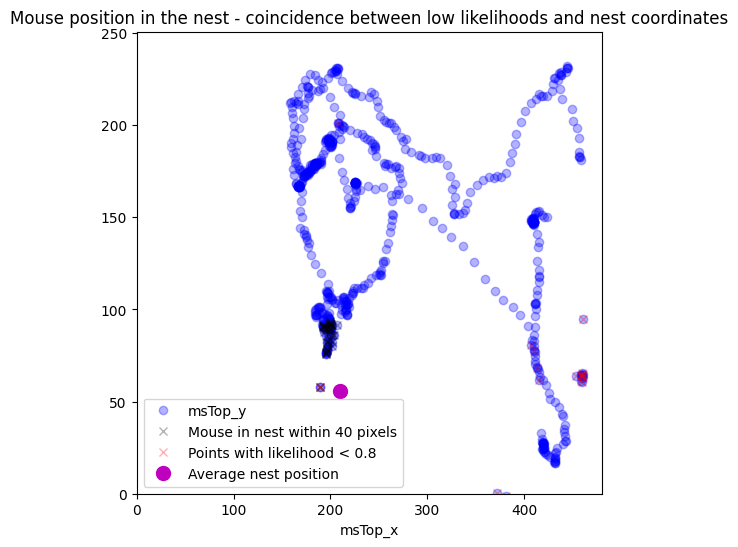

In [11]:
n = 10 # pick n in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
trial_DLC = BF.extract_trial_from_DLC(df_DLC, df_summary, trial_num = n)

min_dist = 40 # pixels
threshold = 0.8 # likelihood

trial_DLC_flagged = BF.flag_nest_coordinates(trial_DLC, minimum_distance_to_nest=min_dist)

# retrieve mask of in_nest coordinates
mask_nest = (trial_DLC_flagged["in_nest"] == True)

# retrieve points with likelihood under 80
mask_low_likelihood = (trial_DLC_flagged["msTop_likelihood"] < threshold)

# plot average of center nest points
nest_avg_x, nest_avg_y = trial_DLC_flagged["centerNest_x"].mean(), trial_DLC_flagged["centerNest_y"].mean()

# plot mouse position and highlight low likelihood points and points in the nest
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
xlim, ylim =  max(trial_DLC_flagged['msTop_x'].max(), trial_DLC_flagged['pup_x'].max()), max(trial_DLC_flagged['msTop_y'].max(), trial_DLC_flagged['pup_y'].max())
trial_DLC_flagged.plot(x='msTop_x', y='msTop_y', style='o', ax=ax, xlim=(0, xlim), ylim=(0, ylim), color = 'blue', alpha = 0.3)
trial_DLC_flagged[mask_nest].plot(x='msTop_x', y='msTop_y', style='x', ax=ax, xlim=(0, xlim), ylim=(0, ylim), color = 'black', alpha = 0.3, label = f"Mouse in nest within {min_dist} pixels")
trial_DLC_flagged[mask_low_likelihood].plot(x='msTop_x', y='msTop_y', style='x', ax=ax, xlim=(0, xlim), ylim=(0, ylim), color = 'r', alpha = 0.3, label = f"Points with likelihood < {threshold}")

# plot the average nest position in magenta
ax.plot(nest_avg_x, nest_avg_y, 'o', color = 'm', markersize = 10, label = "Average nest position")

# add title
ax.set_title("Mouse position in the nest - coincidence between low likelihoods and nest coordinates")

# plot legend
ax.legend()

Visualizing interpolated points

Total nans in the trial: 0
Trial 3 started at 415.2 and ended at 494.93333333333334
Trial 3 started at 0:06:55.200000 and ended at 0:08:14.933333


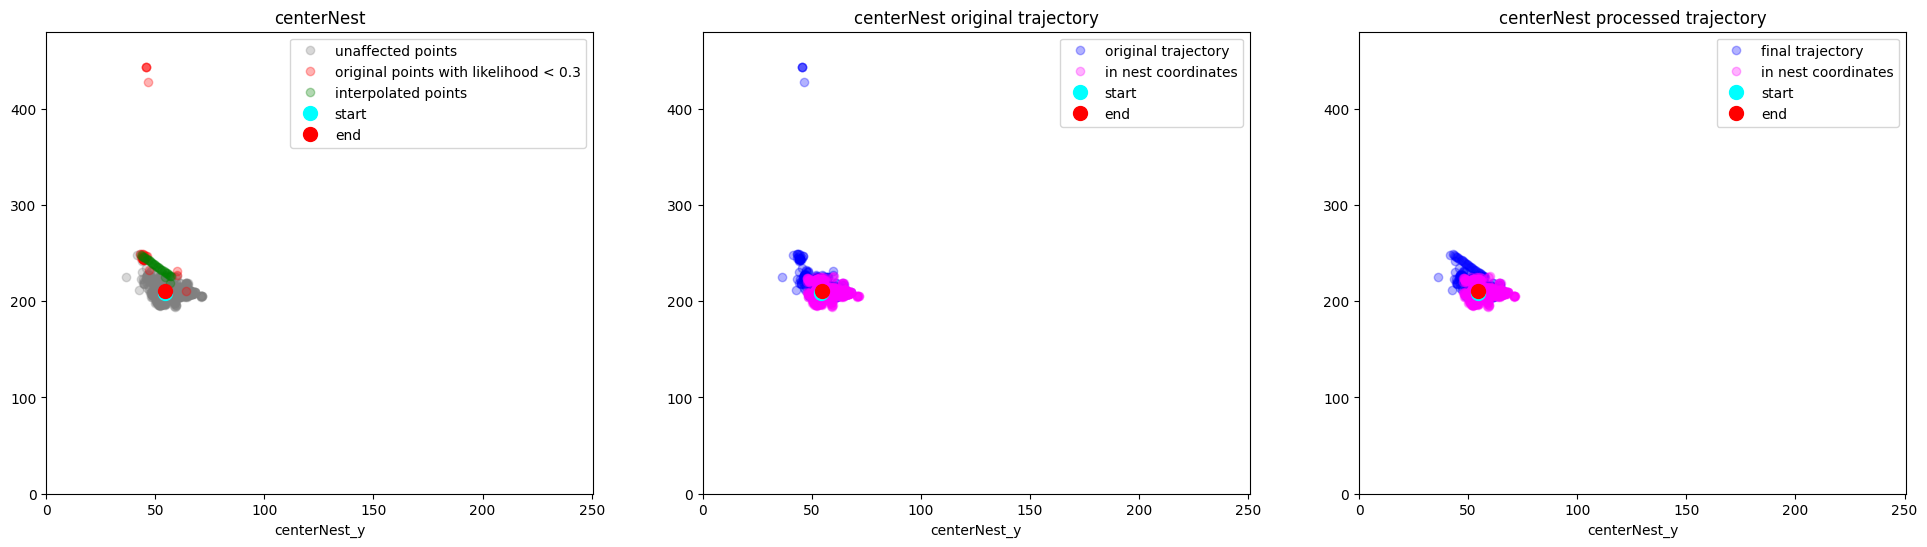

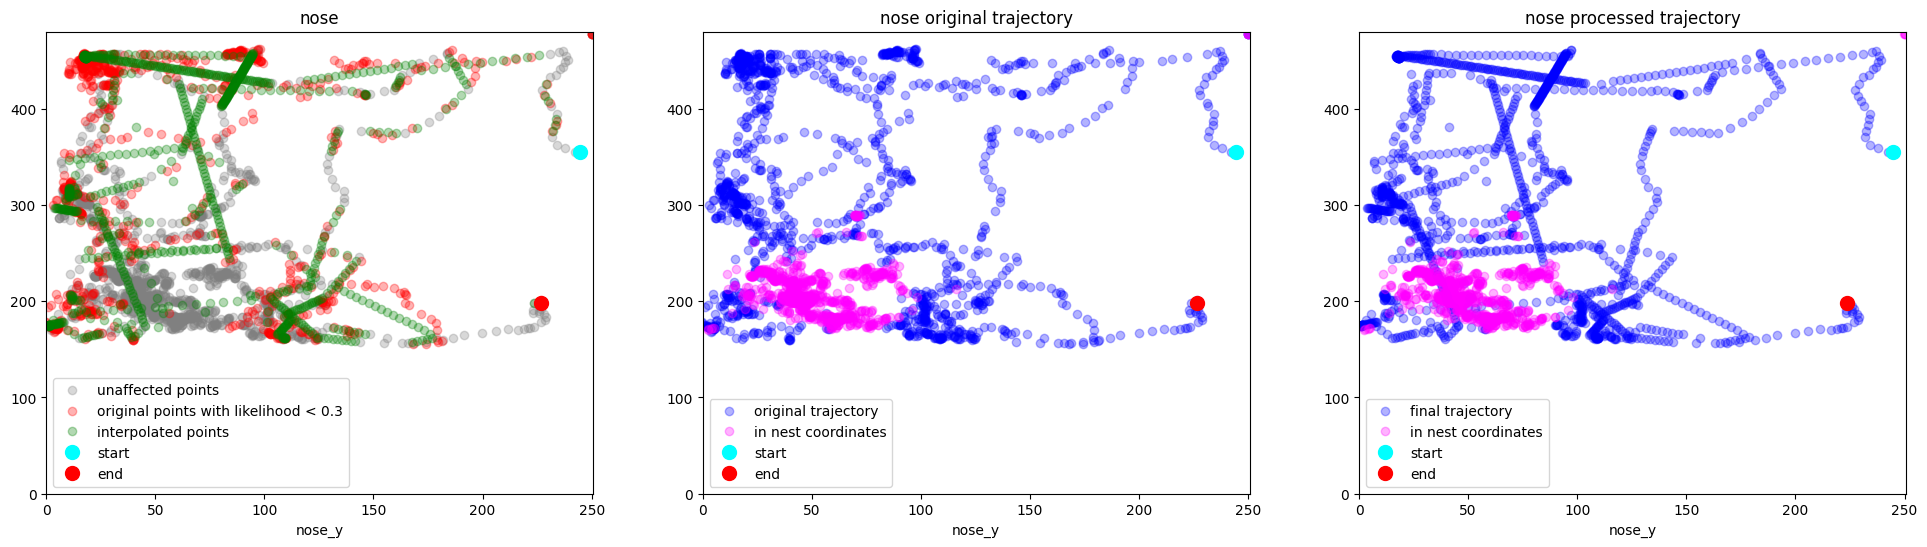

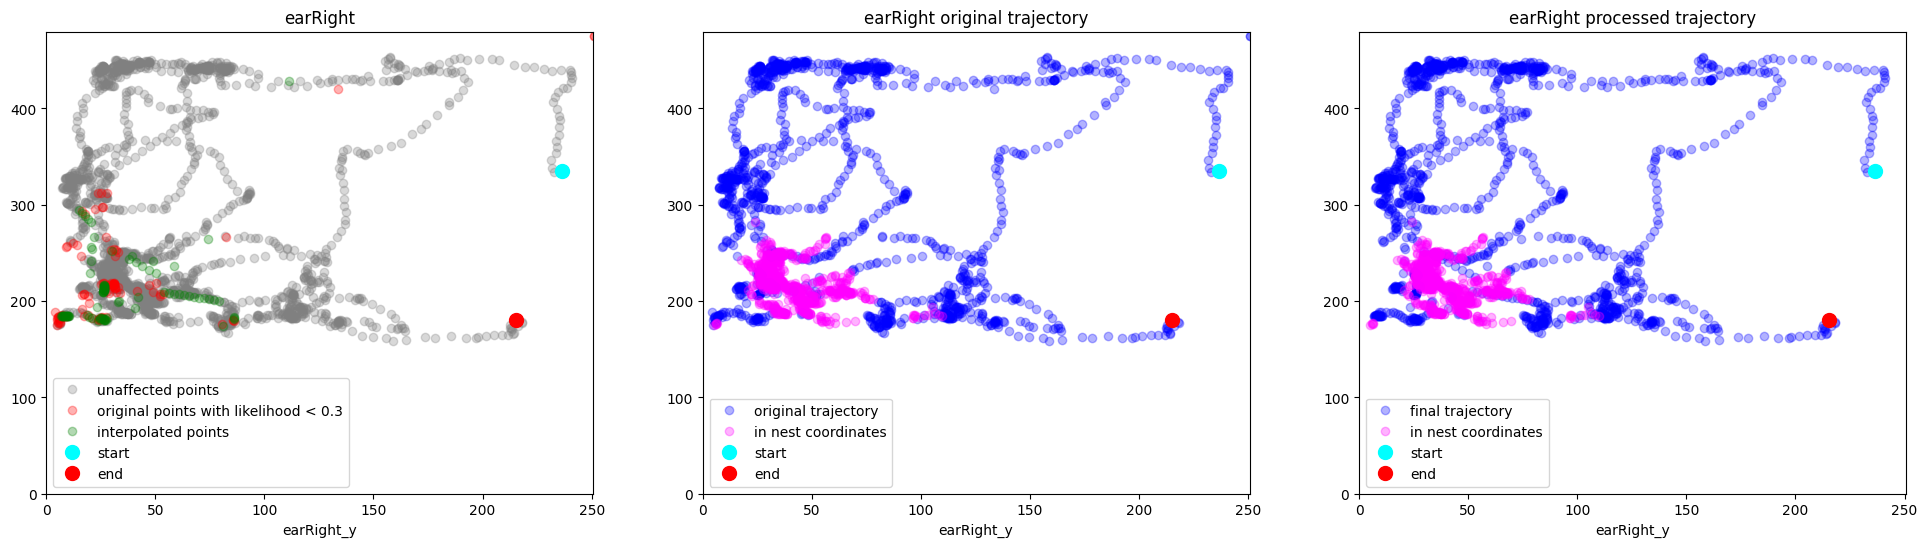

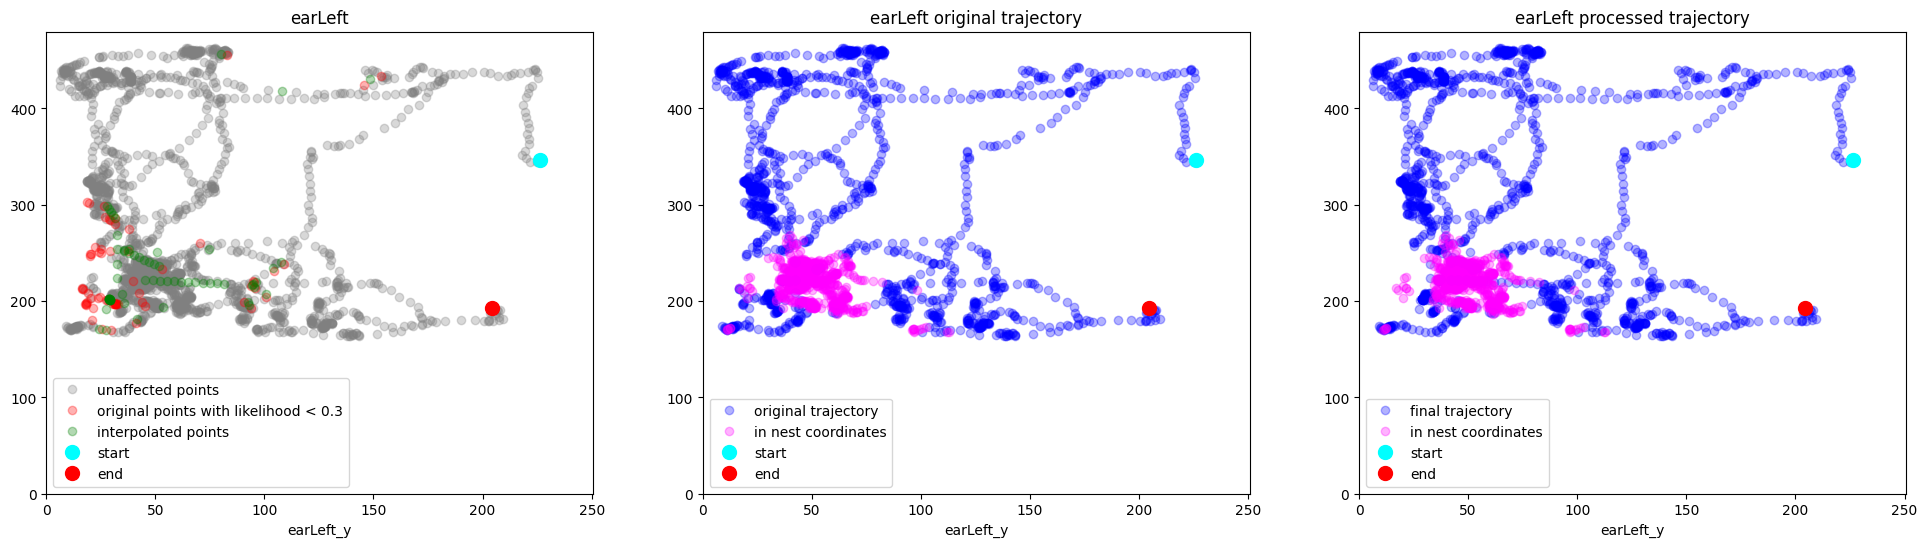

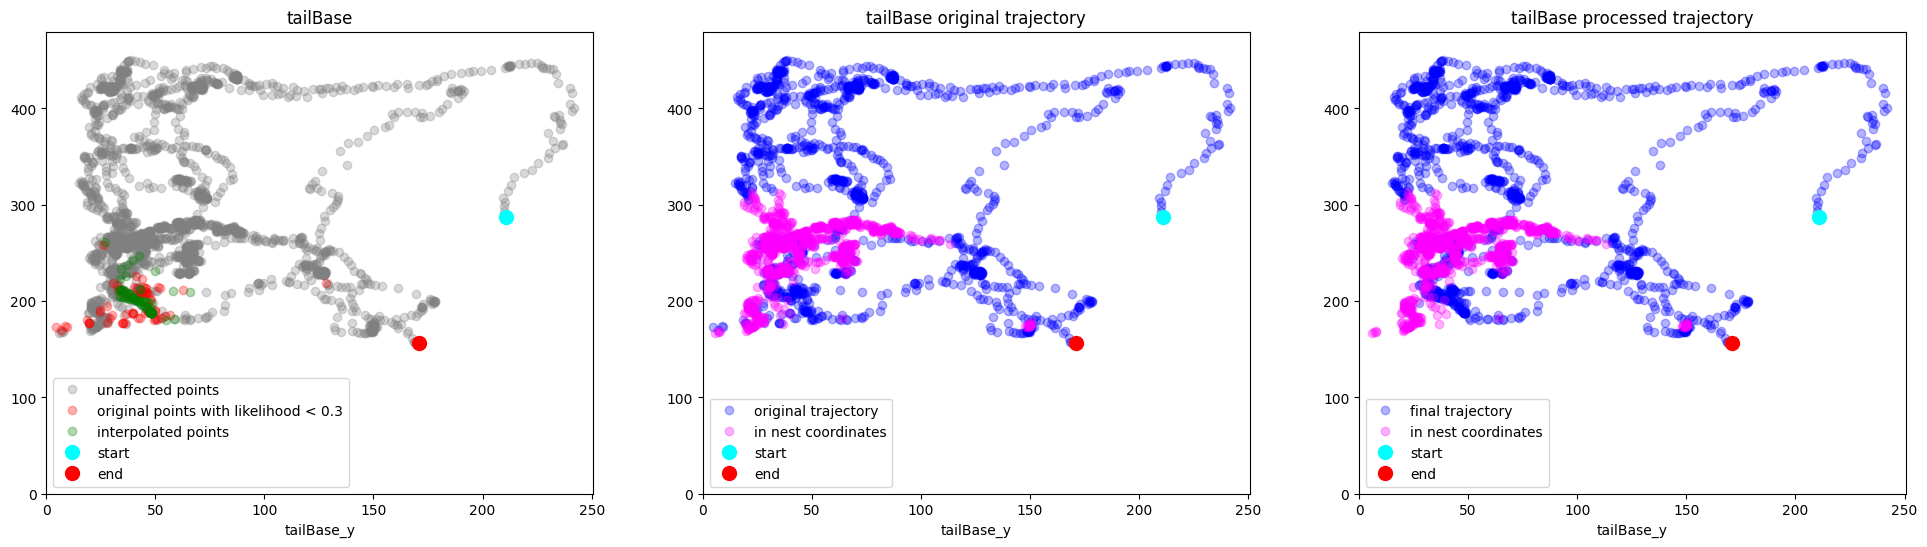

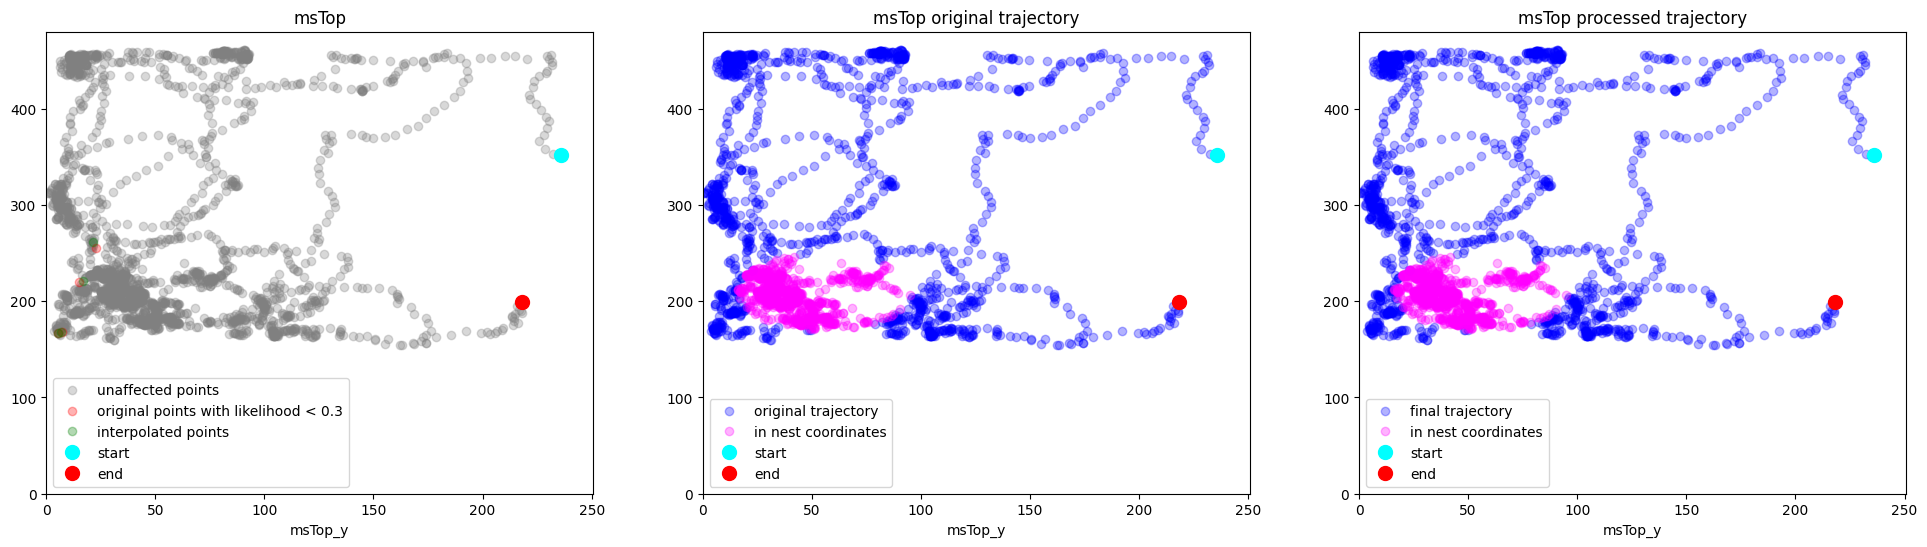

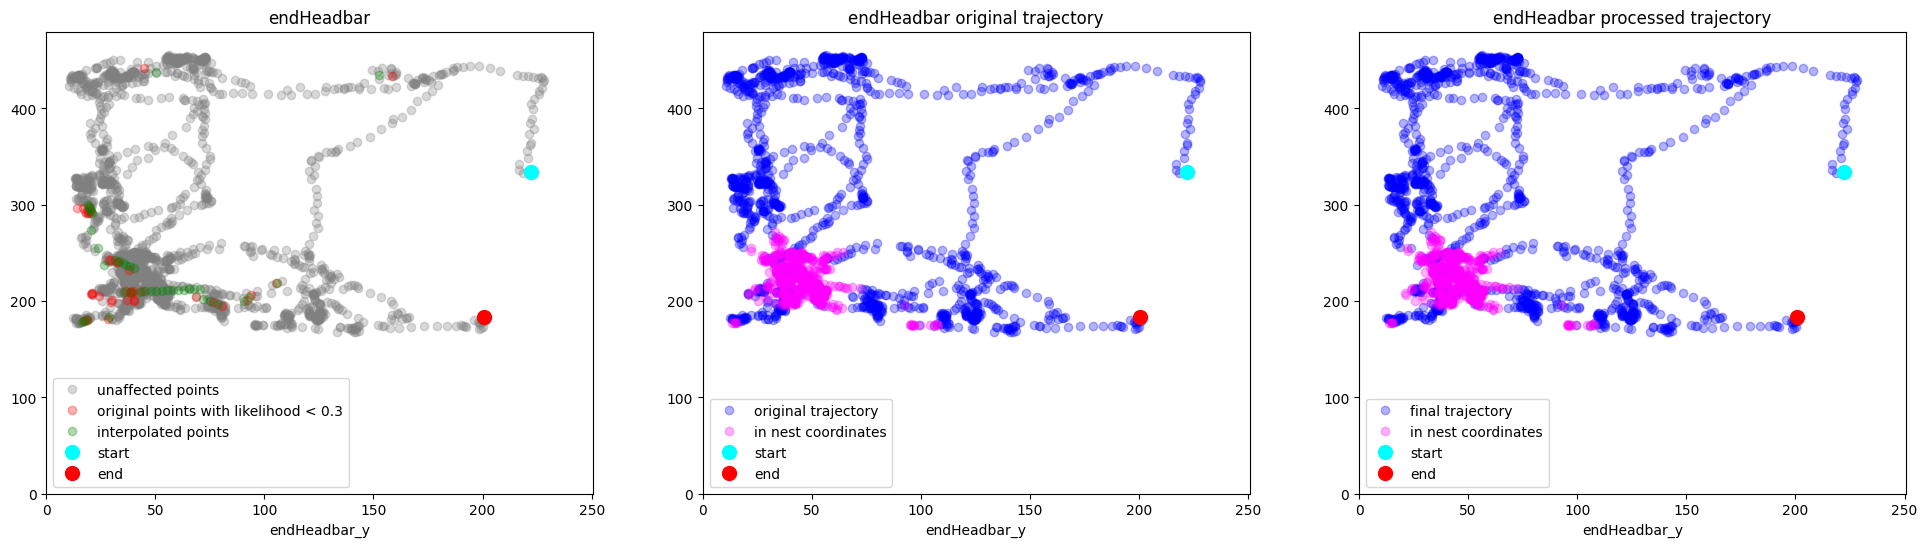

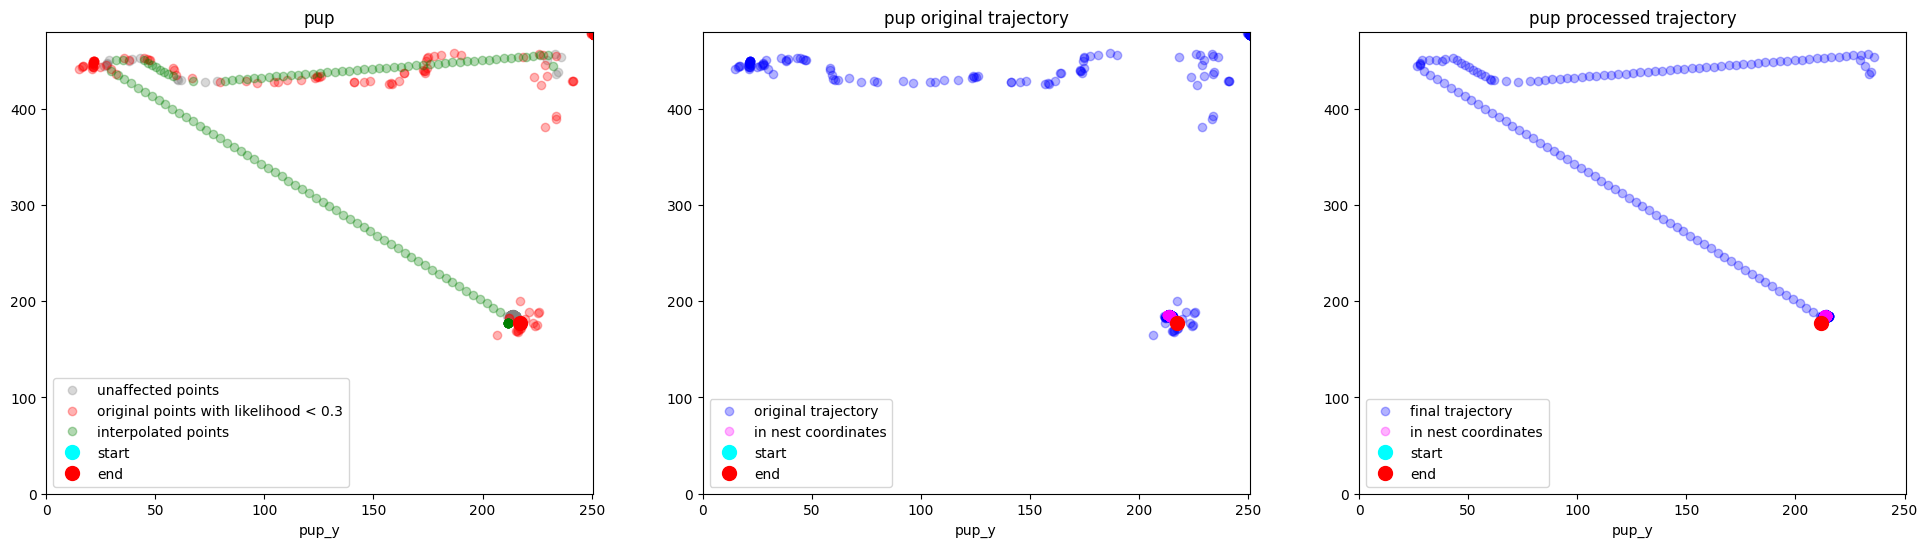

In [30]:
threshold = 0.3
dict_body_parts_to_coords = BF.DLC_cols

day = "d1"
data = DL.get_data_for_experiment(mouse_id = "MBI5335RR",
                                       day = day)
df_DLC = data['Behavior']['df_dlc']
df_summary = data['Behavior']['df_summary']
n = 3 # pick n in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
trial_DLC = BF.extract_trial_from_DLC(df_DLC, df_summary, trial_num = n)

# print total nans
print(f"Total nans in the trial: {trial_DLC.isna().sum().sum()}")

# print start and end times in minutes from the time_seconds column
trial_start_time = trial_DLC["time_seconds"].iloc[0]
trial_end_time = trial_DLC["time_seconds"].iloc[-1]

print(f"Trial {n} started at {trial_start_time} and ended at {trial_end_time}")

print(f"Trial {n} started at {datetime.timedelta(seconds=trial_start_time)} and ended at {datetime.timedelta(seconds=trial_end_time)}")

trial_DLC_flagged = BF.flag_nest_coordinates(trial_DLC, minimum_distance_to_nest=min_dist)
trial_DLC_flagged_intepolated = BF.filter_low_likelihoods_and_interpolate(trial_DLC_flagged,
                                                                          dict_body_parts_to_coords,
                                                                          threshold=threshold)
mask_nest = trial_DLC_flagged["in_nest"]

for body_part in dict_body_parts_to_coords.keys():

    if type(dict_body_parts_to_coords[body_part]) == dict and "likelihood" in dict_body_parts_to_coords[body_part]:


        mask_interpolated =(trial_DLC_flagged[dict_body_parts_to_coords[body_part]["likelihood"]] < threshold) & (~mask_nest)

        # plot trajectory that was not interpolated in blue, label = "original points with high likelihood or in the nest"

        # create fig
        fig, ax = plt.subplots(1, 3, figsize=(24, 6))

        trial_DLC_flagged.loc[~mask_interpolated].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                                       style='o', ax=ax[0], xlim=(0, ylim), ylim=(0, xlim), color = 'grey', alpha = 0.3, label = "unaffected points")

        # plot original points in red if likelihood is low, label = "original points with low likelihood"
        trial_DLC_flagged.loc[mask_interpolated].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                                       style='o', ax=ax[0], xlim=(0, ylim), ylim=(0, xlim), color = 'red', alpha = 0.3, label = f"original points with likelihood < {threshold}")

        # plot interpolated points in green if likelihood is low and mouse is out of the nest, label = "interpolated points"
        trial_DLC_flagged_intepolated.loc[mask_interpolated].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                                       style='o', ax=ax[0], xlim=(0, ylim), ylim=(0, xlim), color = 'green', alpha = 0.3, label = "interpolated points")
        
        # plot original trajectory

        trial_DLC_flagged[~mask_nest].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                             style='o', ax=ax[1], xlim=(0, ylim), ylim=(0, xlim), color = 'blue', alpha = 0.3, label = "original trajectory")
        
        trial_DLC_flagged[mask_nest].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                           style='o', ax=ax[1], xlim=(0, ylim), ylim=(0, xlim), color = 'magenta', alpha = 0.3, label = "in nest coordinates")
        

        # plot final trajectory
        trial_DLC_flagged_intepolated[~mask_nest].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                           style='o', ax=ax[2], xlim=(0, ylim), ylim=(0, xlim), color = 'blue', alpha = 0.3, label = "final trajectory")
        
        trial_DLC_flagged_intepolated[mask_nest].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                           style='o', ax=ax[2], xlim=(0, ylim), ylim=(0, xlim), color = 'magenta', alpha = 0.3, label = "in nest coordinates")
        

        # mark the first point of the trajectory as a green dot, markersize = 10, label = "start"
        ax[0].plot(trial_DLC_flagged[dict_body_parts_to_coords[body_part]["y"]].iloc[0], trial_DLC_flagged_intepolated[dict_body_parts_to_coords[body_part]["x"]].iloc[0], 'o', color = 'cyan', markersize = 10, label = "start")
        ax[1].plot(trial_DLC_flagged[dict_body_parts_to_coords[body_part]["y"]].iloc[0], trial_DLC_flagged_intepolated[dict_body_parts_to_coords[body_part]["x"]].iloc[0], 'o', color = 'cyan', markersize = 10, label = "start")
        ax[2].plot(trial_DLC_flagged_intepolated[dict_body_parts_to_coords[body_part]["y"]].iloc[0], trial_DLC_flagged_intepolated[dict_body_parts_to_coords[body_part]["x"]].iloc[0], 'o', color = 'cyan', markersize = 10, label = "start")

        # mark the last point of the trajectory as a red dot, markersize = 10, label = "end"
        ax[0].plot(trial_DLC_flagged[dict_body_parts_to_coords[body_part]["y"]].iloc[-1], trial_DLC_flagged_intepolated[dict_body_parts_to_coords[body_part]["x"]].iloc[-1], 'o', color = 'red', markersize = 10, label = "end")
        ax[1].plot(trial_DLC_flagged[dict_body_parts_to_coords[body_part]["y"]].iloc[-1], trial_DLC_flagged_intepolated[dict_body_parts_to_coords[body_part]["x"]].iloc[-1], 'o', color = 'red', markersize = 10, label = "end")
        ax[2].plot(trial_DLC_flagged_intepolated[dict_body_parts_to_coords[body_part]["y"]].iloc[-1], trial_DLC_flagged_intepolated[dict_body_parts_to_coords[body_part]["x"]].iloc[-1], 'o', color = 'red', markersize = 10, label = "end")

        # set title of body part as title of the plot
        ax[0].set_title(body_part)
        ax[1].set_title(body_part+ " original trajectory")
        ax[2].set_title(body_part+ " processed trajectory")

        # plot legend
        ax[0].legend()
        ax[1].legend()     
        ax[2].legend() 





### Computing Base Parameters ###

In [41]:
trial_1_DLC = BF.extract_trial_from_DLC(df_DLC, df_summary, trial_num = 3)
trial_1_DLC = BF.flag_nest_coordinates(trial_1_DLC, minimum_distance_to_nest=40)
trial_1_DLC = BF.filter_low_likelihoods_and_interpolate(trial_1_DLC, dict_body_parts_to_coords, threshold=0.3)
mask = (trial_1_DLC["in_nest"] == False)

Speed

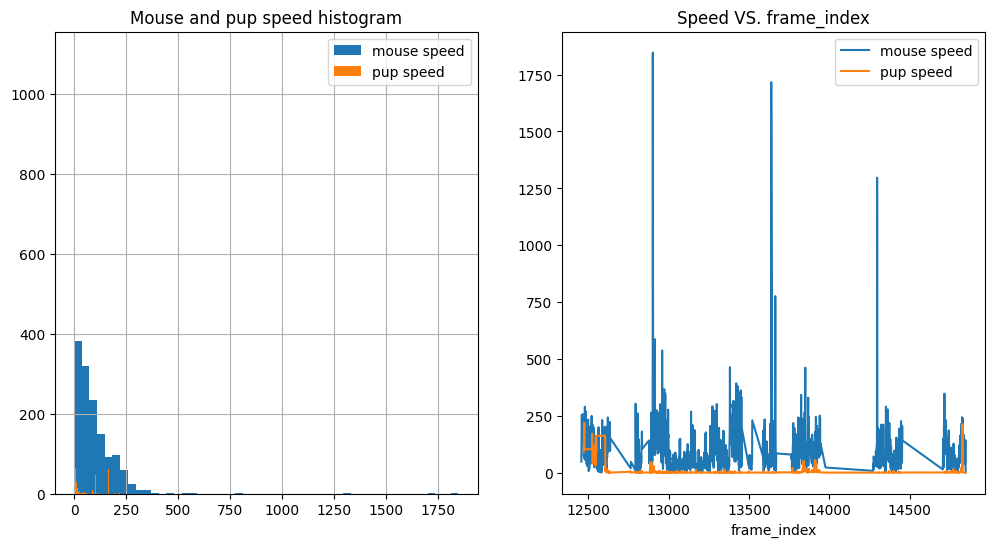

In [42]:
mouse_speed_col = 'mouse_speed_px/s'
pup_speed_col = 'pup_speed_px/s'

trial_1_DLC = BF.compute_speed(trial_1_DLC, x_col = 'msTop_x', y_col = 'msTop_y', speed_col = mouse_speed_col)
trial_1_DLC = BF.compute_speed(trial_1_DLC, x_col = 'pup_x', y_col = 'pup_y', speed_col = pup_speed_col)

# create a grid of 2 histogram plots one for mouse speed and one for pup speed
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# histogram of speed

trial_1_DLC[mask][mouse_speed_col].hist(bins=50, ax=ax[0], label = 'mouse speed')
trial_1_DLC[mask][pup_speed_col].hist(bins=50, ax=ax[0], label = 'pup speed')
ax[0].set_title('Mouse and pup speed histogram')  # set title
ax[0].legend()  # show legend

# histogram of speed
trial_1_DLC[mask].plot(x='frame_index', y=mouse_speed_col, ax=ax[1], label = 'mouse speed')
trial_1_DLC[mask].plot(x='frame_index', y=pup_speed_col, ax=ax[1], label = 'pup speed')

ax[1].set_title('Speed VS. frame_index')  # set title
ax[1].legend()  # show legend

Distance to pup

Text(0.5, 0, 'Distance (px)')

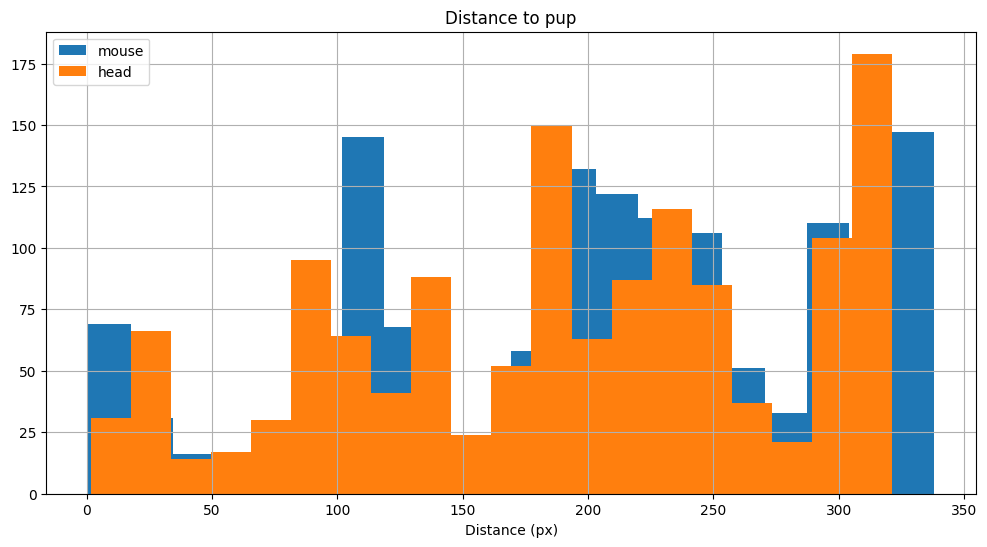

In [43]:
distance_mouse_to_pup = 'distance_mouse_to_pup'
distance_head_to_pup = 'distance_head_to_pup'
head_x_col, head_y_col = 'endHeadbar_x','endHeadbar_y'

trial_1_DLC = BF.compute_distance_to_pup(trial_1_DLC, distance_col = distance_mouse_to_pup)
trial_1_DLC  = BF.compute_distance_to_pup(trial_1_DLC, distance_col = distance_head_to_pup, x_col = head_x_col, y_col = head_y_col)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

trial_1_DLC[mask][distance_mouse_to_pup].hist(bins=20, ax=ax, label = 'mouse')
trial_1_DLC[mask][distance_head_to_pup].hist(bins=20, ax=ax, label = 'head')

ax.legend()

ax.set_title('Distance to pup')  # set title
ax.set_xlabel('Distance (px)')  # set x label

Head angle to pup

Text(0.5, 0, 'Angle (degrees)')

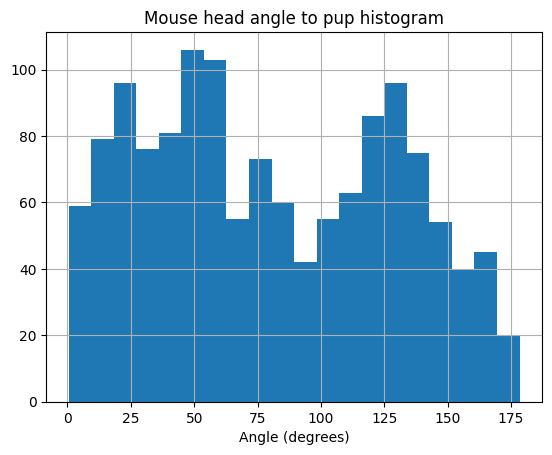

In [44]:
head_angle_to_pup_col = 'head_angle_to_pup_degrees'

trial_1_DLC = BF.compute_head_angle_to_pup(trial_1_DLC, add_vector_columns = True, head_angle_to_pup_col=head_angle_to_pup_col)

trial_1_DLC[mask][head_angle_to_pup_col].hist(bins=20)
# set title
plt.title('Mouse head angle to pup histogram')
plt.xlabel('Angle (degrees)')  # set x-axis label

Visualize head angle to pup

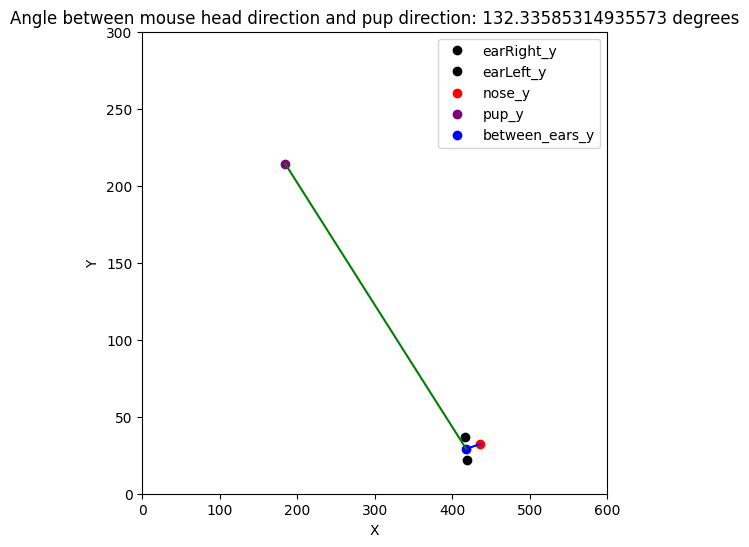

In [60]:
plot_mouse_angle_to_pup(trial_1_DLC, ylim = 300 , xlim = 600)

Process full file (df_DLC)

In [18]:
df_DLC_updated, trials_dict = BF.extract_base_parameters(df_DLC, df_summary)

Processing trial 1 Start frame: 11072 End frame: 11538
Trial 1 started at 0:06:09.082000 and ended at 0:06:24.586000
Trial 1 started at 369.082 and ended at 384.586
Processing trial 2 Start frame: 11901 End frame: 12085
Trial 2 started at 0:06:36.698000 and ended at 0:06:42.842000
Trial 2 started at 396.698 and ended at 402.842
Processing trial 3 Start frame: 12456 End frame: 14848
Trial 3 started at 0:06:55.186000 and ended at 0:08:14.930000
Trial 3 started at 415.186 and ended at 494.93
Processing trial 4 Start frame: 15232 End frame: 15940
Trial 4 started at 0:08:27.722000 and ended at 0:08:51.348000
Trial 4 started at 507.722 and ended at 531.348
Processing trial 5 Start frame: 16418 End frame: 19682
Trial 5 started at 0:09:07.266000 and ended at 0:10:56.083000
Trial 5 started at 547.266 and ended at 656.083
Processing trial 6 Start frame: 19972 End frame: 20270
Trial 6 started at 0:11:05.746000 and ended at 0:11:15.674000
Trial 6 started at 665.746 and ended at 675.674
Processing 

In [19]:
df_DLC_updated.head(3)

,frame_index,time_seconds,msTop_x,msTop_y,msTop_likelihood,endHeadbar_x,endHeadbar_y,endHeadbar_likelihood,earRight_x,earRight_y,...,centerNest_y,centerNest_likelihood,pup_x,pup_y,pup_likelihood,ms_speed_px/s,pup_speed_px/s,distance_head_to_pup,distance_mouse_to_pup,head_angle_to_pup_degrees
151,151,5.033333,170.865509,89.811813,0.961542,190.735977,79.387955,0.943847,174.400299,80.521759,...,57.566437,0.910896,477.403198,251.108810,0.074489,NaN,NaN,NaN,NaN,NaN
152,152,5.066667,170.884583,89.919662,0.960909,190.975998,79.499725,0.941302,174.574753,80.326324,...,57.520256,0.904566,477.380341,251.101379,0.074293,NaN,NaN,NaN,NaN,NaN
153,153,5.100000,170.883240,90.323051,0.961621,191.376846,80.730232,0.936073,174.205078,80.630722,...,57.570263,0.890773,477.362000,251.079193,0.073658,NaN,NaN,NaN,NaN,NaN


In [20]:
print("Elements of trials_dict:", trials_dict.keys())
trials_dict[1].head(3)

Elements of trials_dict: dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


,frame_index,time_seconds,msTop_x,msTop_y,msTop_likelihood,endHeadbar_x,endHeadbar_y,endHeadbar_likelihood,earRight_x,earRight_y,...,centerNest_likelihood,pup_x,pup_y,pup_likelihood,ms_speed_px/s,pup_speed_px/s,distance_head_to_pup,distance_mouse_to_pup,head_angle_to_pup_degrees,in_nest
11072,11072,369.066667,211.098618,66.026276,0.262119,194.405746,59.853741,0.227935,185.651154,50.854977,...,0.916788,476.207092,250.759369,0.072639,678.147748,2.601532,340.377669,323.123535,168.637007,True
11073,11073,369.100000,203.101562,44.883198,0.139015,197.106476,60.143154,0.255601,202.642029,74.405647,...,0.923038,476.192139,250.844788,0.073462,706.092491,0.020415,338.017633,342.050638,42.849802,True
11074,11074,369.133333,213.183609,66.150902,0.735463,200.254944,52.229858,0.362945,206.455994,69.558716,...,0.968162,476.192780,250.845016,0.073472,661.431953,0.004578,339.984809,321.380989,30.279216,True


## Detecting higher level behaviours ##

Carrying

Approach

Crouching/Sniffing/Licking/Grooming

# Behavioural windows #

### Behavioural Windows (+/- 2s) around key events ###

In [21]:
def extract_feature_behavioural_window(behaviour_col, trial_num, df_DLC, df_summary, window_size = 60):

    # get the trial
    trial_metadata = df_summary[df_summary['TrialNum'] == trial_num]
    BehavRecdTrialEndSecs = trial_metadata['BehavRecdTrialEndSecs'].values[0]

    # nan check
    if np.isnan(BehavRecdTrialEndSecs):
        warnings.warn("BehavRecdTrialEndSecs is NaN")
        return None
    
    end_frame = BF.convert_seconds_to_frame(BehavRecdTrialEndSecs)
    start_frame = end_frame - window_size

    pass
    # return a slice of the dataframe with the features speed, head_angle, distance to pup, extracted

### Pre-event behavioural window (-Xs preceding key event) ###

In [22]:
def extract_feature_pre_event_window(behaviour_col, trial_num, df_DLC, df_summary, pre_event_window_size = 100):

    pass

### Analyzing parameters ###

In [23]:
def analyze_trajectory(df_DLC, start_frame, end_frame):
    
    print("Trajectory detected from frame {} to frame {}".format(start_frame, end_frame))
    